<a href="https://colab.research.google.com/github/Char15Xu/nndl_final_proj/blob/main/convnext_clip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Description:
    This notebook implements a dual-model architecture for hierarchical multi-class image classification.
    - ConvNeXt is used for superclass prediction
    - CLIP (ViT-B-32 or ViT-B-16) is used for subclass prediction.
Optimization techniques used:
    - Data augmentation (RandomResizedCrop, RandomHorizontalFlip, etc.)
    - Parameter reduction (Freezing CLIP visual backbone and training only a linear head)
    - Weight decay regularization (AdamW optimizer with weight_decay=0.05)
    - Early stopping based on validation loss (to prevent overfitting)
    - Stochastic regularization (ConvNeXt uses DropPath)
    - Reproducible random seed for dataset splitting
    - (Optional) Ensemble predictions for further robustness (not enabled by default)

Author: Charles Xu (tx2263)
Date: 2025-05-13
Credit: This notebook has adopted MultiClassImageDataset and MultiClassImageTestDataset from NNDL simple_cnn_demo file.
"""

'\nDescription:\n    This notebook implements a dual-model architecture for hierarchical multi-class image classification.\n    - ConvNeXt is used for superclass prediction \n    - CLIP (ViT-B-32 or ViT-B-16) is used for subclass prediction.\nOptimization techniques used:\n    - Data augmentation (RandomResizedCrop, RandomHorizontalFlip, etc.)\n    - Parameter reduction (Freezing CLIP visual backbone and training only a linear head)\n    - Weight decay regularization (AdamW optimizer with weight_decay=0.05)\n    - Early stopping based on validation loss (to prevent overfitting)\n    - Stochastic regularization (ConvNeXt uses DropPath)\n    - Reproducible random seed for dataset splitting\n    - Efficient batch loading with multiprocessing and pin_memory\n    - (Optional) Ensemble predictions for further robustness (not enabled by default) \n\nAuthor: Charles Xu (tx2263)\nDate: 2025-05-13\nCredit: This notebook has adopted MultiClassImageDataset and MultiClassImageTestDataset from NNDL 

### 1. Setup
#### The following cells in this section setup dependencies, file paths, and util tools.

In [ ]:
import os, random, torch, torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, BatchSampler, random_split, Subset
from torchvision import transforms
from PIL import Image
from pathlib import Path
from tqdm import tqdm
import csv, json
!pip install -q timm open_clip_torch torchmetrics==1.3.2
import timm, open_clip

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
root = '/content/drive/MyDrive/Released_Data_NNDL_2025'
!unzip -q "/content/drive/MyDrive/Validation/train_images.zip" -d /content/images
!unzip -q "/content/drive/MyDrive/Released_Data_NNDL_2025/test_images.zip" -d /content/images

replace /content/images/__MACOSX/._train_images? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
replace /content/images/__MACOSX/._test_images? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
# Create Dataset class for multilabel classification
# Credit: NNDL Simple_cnn_demo file
# Summary: This code block defines two classes for clean loading of dataset. They both support Dataload and data
# processing with pytorch.

class MultiClassImageDataset(Dataset):
    def __init__(self, ann_df, super_map_df, sub_map_df, img_dir, transform=None):
        self.ann_df = ann_df
        self.super_map_df = super_map_df
        self.sub_map_df = sub_map_df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.ann_df)

    def __getitem__(self, idx):
        img_name = self.ann_df['image'][idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        super_idx = self.ann_df['superclass_index'][idx]
        super_label = self.super_map_df['class'][super_idx]

        sub_idx = self.ann_df['subclass_index'][idx]
        sub_label = self.sub_map_df['class'][sub_idx]

        if self.transform:
            image = self.transform(image)

        return image, super_idx, super_label, sub_idx, sub_label

class MultiClassImageTestDataset(Dataset):
    def __init__(self, super_map_df, sub_map_df, img_dir, transform=None):
        self.super_map_df = super_map_df
        self.sub_map_df = sub_map_df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self): # Count files in img_dir
        return len([fname for fname in os.listdir(self.img_dir)])

    def __getitem__(self, idx):
        img_name = str(idx) + '.jpg'
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, img_name

### 2. Data Visualization
#### This cell performs data reading and visualization.

train_df:              6288 samples
balanced_train_df:     5088  | balanced_val_df: 1200
adversarial_train_df:  4601  | adversarial_val_df: 1687
train_like_train_df:   5030  | train_like_val_df: 1258
novel_train_df:        5488  | novel_val_df: 861


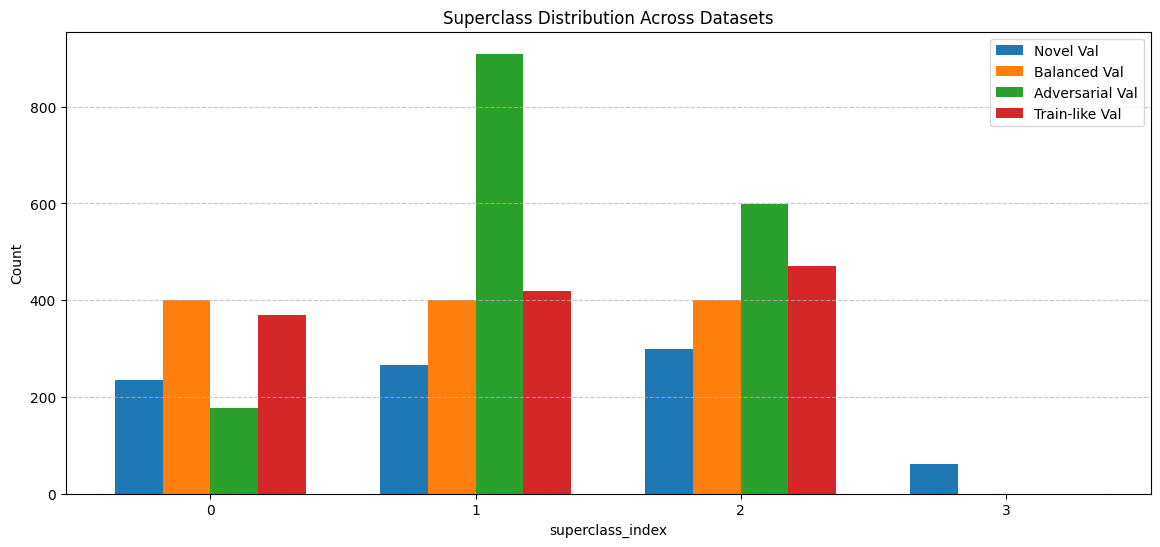

In [ ]:
# Data paths
train_path = "/content/drive/MyDrive/Released_Data_NNDL_2025/train_data.csv"

balanced_val_path = "/content/drive/MyDrive/Validation/balanced_val.csv"
balanced_train_path = "/content/drive/MyDrive/Validation/balanced_train.csv"

adversarial_val_path = "/content/drive/MyDrive/Validation/adversarial_val.csv"
adversarial_train_path = "/content/drive/MyDrive/Validation/adversarial_train.csv"

train_like_val_path = "/content/drive/MyDrive/Validation/train_like_val.csv"
train_like_train_path = "/content/drive/MyDrive/Validation/train_like_train.csv"

novel_val_path = "/content/drive/MyDrive/Validation/novel_val.csv"
novel_train_path = "/content/drive/MyDrive/Validation/novel_train.csv"

# Load dataframes
train_df = pd.read_csv(train_path)

balanced_val_df = pd.read_csv(balanced_val_path)
balanced_train_df = pd.read_csv(balanced_train_path)

adversarial_val_df = pd.read_csv(adversarial_val_path)
adversarial_train_df = pd.read_csv(adversarial_train_path)

train_like_val_df = pd.read_csv(train_like_val_path)
train_like_train_df = pd.read_csv(train_like_train_path)

novel_val_df = pd.read_csv(novel_val_path)
novel_train_df = pd.read_csv(novel_train_path)

print(f"train_df:              {len(train_df)} samples")
print(f"balanced_train_df:     {len(balanced_train_df)}  | balanced_val_df: {len(balanced_val_df)}")
print(f"adversarial_train_df:  {len(adversarial_train_df)}  | adversarial_val_df: {len(adversarial_val_df)}")
print(f"train_like_train_df:   {len(train_like_train_df)}  | train_like_val_df: {len(train_like_val_df)}")
print(f"novel_train_df:        {len(novel_train_df)}  | novel_val_df: {len(novel_val_df)}")

def plot_distribution(df_list, labels, column, title):
    """
    This function plots the distribution of a specific column across multiple datasets.
    """
    plt.figure(figsize=(14, 6))
    all_classes = sorted(set().union(*[df[column].unique() for df in df_list]))
    x = np.arange(len(all_classes))
    width = 0.18

    for i, (df, label) in enumerate(zip(df_list, labels)):
        counts = df[column].value_counts().reindex(all_classes, fill_value=0)
        plt.bar(x + i * width, counts.values, width=width, label=label)

    plt.xlabel(f'{column}')
    plt.ylabel('Count')
    plt.title(title)
    plt.xticks(x + width*1.5, all_classes)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# [GRAPH] Uncomment to view validation set superclass distribution plot
plot_distribution(
    [novel_val_df, balanced_val_df, adversarial_val_df, train_like_val_df],
    ['Novel Val', 'Balanced Val', 'Adversarial Val', 'Train-like Val'],
    'superclass_index',
    'Superclass Distribution Across Datasets'
)

# [GRAPH] Uncomment to view validation set subclass distribution plot
# plot_distribution(
#     [novel_df, balanced_df, adversarial_df, train_like_df],
#     ['Novel Val', 'Balanced Val', 'Adversarial Val', 'Train-like Val'],
#     'subclass_index',
#     'Subclass Distribution Across Datasets'
# )

### 3.  Data loading and preprocessing
#### This cell loads and generates training, and validation datasets and preprocess images for each model.

In [ ]:
train_img_dir = '/content/images/train_images'
test_img_dir = '/content/images/test_images'
superclass_mapping_path = "/content/drive/MyDrive/Released_Data_NNDL_2025/superclass_mapping.csv"
subclass_mapping_path = "/content/drive/MyDrive/Released_Data_NNDL_2025/subclass_mapping.csv"
super_map_df = pd.read_csv(superclass_mapping_path)
sub_map_df = pd.read_csv(subclass_mapping_path)
num_super = len(super_map_df)
num_sub   = len(sub_map_df)

# Create train and val split
train_dataset = MultiClassImageDataset(train_df, super_map_df, sub_map_df, train_img_dir, transform=None)
train_dataset = MultiClassImageDataset(train_df, super_map_df, sub_map_df, train_img_dir, transform=None)
generator = torch.Generator().manual_seed(42)
train_len = int(len(train_dataset) * 0.9)
val_len   = len(train_dataset) - train_len
train_idx, val_idx = random_split(range(len(train_dataset)), [train_len, val_len], generator=generator)

# Define ConvNeXt image preprocessing transformation base on standard ImageNet stats
imnet_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

conv_train_tf = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.6,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    imnet_normalize,
])

conv_val_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    imnet_normalize,
])

# Define CLIP (open_clip) model and preprocessor
clip_model, _, clip_preprocess = open_clip.create_model_and_transforms(
    "ViT-B-32", pretrained="laion2b_s34b_b79k"
)

# Create training and validation dataset for ConvNeXt and CLIP respectfully
conv_train_ds = Subset(
    MultiClassImageDataset(train_df, super_map_df, sub_map_df, train_img_dir, transform=conv_train_tf),
    train_idx
)
conv_val_ds   = Subset(
    MultiClassImageDataset(train_df, super_map_df, sub_map_df, train_img_dir, transform=conv_val_tf),
    val_idx
)
clip_train_ds = Subset(
    MultiClassImageDataset(train_df, super_map_df, sub_map_df, train_img_dir, transform=clip_preprocess),
    train_idx
)
clip_val_ds   = Subset(
    MultiClassImageDataset(train_df, super_map_df, sub_map_df, train_img_dir, transform=clip_preprocess),
    val_idx
)

# Initialize dataloaders
BATCH = 32
conv_train_loader = DataLoader(conv_train_ds, batch_size=BATCH, shuffle=True)
conv_val_loader   = DataLoader(conv_val_ds,   batch_size=BATCH, shuffle=False)
clip_train_loader = DataLoader(clip_train_ds, batch_size=BATCH, shuffle=True)
clip_val_loader   = DataLoader(clip_val_ds,   batch_size=BATCH, shuffle=False)

### 4. Model

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize ConvNeXt‑Tiny for predicting super‑class
convnext = timm.create_model("convnext_tiny", pretrained=True, num_classes=num_super).to(device)

# Freezing the CLIP backbone and train the linear head to predict sub‑class
clip_model.visual.requires_grad_(False)
clip_model = clip_model.to(device)
linear_head = nn.Linear(clip_model.visual.output_dim, num_sub).to(device)

In [ ]:
# Optimizers
ce = nn.CrossEntropyLoss()
conv_opt = torch.optim.AdamW(convnext.parameters(), lr=3e-4, weight_decay=0.05)
clip_opt = torch.optim.Adam(linear_head.parameters(), lr=1e-3)

# ConvNeXt trainer
def convnext_train(loader):
    convnext.train()
    num_samples, num_correct = 0, 0
    losses = 0.0

    for imgs, sup_y, _, _, _ in tqdm(loader):
        imgs = imgs.to(device)
        sup_y = sup_y.to(device)

        # Forward pass
        logits = convnext(imgs)
        loss = ce(logits, sup_y)

        # Backward pass and optimizer
        conv_opt.zero_grad()
        loss.backward()
        conv_opt.step()

        batch_size = imgs.size(0)
        losses += loss.item() * batch_size

        preds = logits.argmax(dim=1)
        correct = (preds == sup_y).sum().item()
        num_correct += correct
        num_samples += batch_size

    train_loss = losses / num_samples
    train_acc = num_correct / num_samples

    return train_loss, train_acc


# ConvNeXt evaluator
@torch.no_grad()
def convnext_eval(loader):
    convnext.eval()
    num_samples, num_correct = 0, 0
    losses = 0.0

    for imgs, sup_y, _, _, _ in loader:
        imgs = imgs.to(device)
        sup_y = sup_y.to(device)

        # Forward pass
        logits = convnext(imgs)
        loss = ce(logits, sup_y)

        batch_size = imgs.size(0)
        losses += loss.item() * batch_size

        preds = logits.argmax(dim=1)
        correct = (preds == sup_y).sum().item()
        num_correct += correct
        num_samples += batch_size

    val_loss = losses / num_samples
    val_acc = num_correct / num_samples

    return val_loss, val_acc


# CLIP trainer
def clip_epoch(loader):
    clip_model.eval()
    linear_head.train()

    num_samples, num_correct = 0, 0
    losses = 0.0

    for imgs, _, _, y_sub, _ in tqdm(loader):
        imgs = imgs.to(device)
        y_sub = y_sub.to(device)

        # Get CLIP features
        with torch.no_grad():
            features = clip_model.visual(imgs)

        # Forward pass
        logits = linear_head(features)
        loss = ce(logits, y_sub)

        # Backward pass and optimizer
        clip_opt.zero_grad()
        loss.backward()
        clip_opt.step()

        batch_size = imgs.size(0)
        losses += loss.item() * batch_size

        preds = logits.argmax(dim=1)
        correct = (preds == y_sub).sum().item()
        num_correct += correct
        num_samples += batch_size

    train_loss = losses / num_samples
    train_acc = num_correct / num_samples

    return train_loss, train_acc

# CLIP evaluator
@torch.no_grad()
def clip_eval(loader):
    clip_model.eval()
    linear_head.eval()

    num_samples, num_correct = 0, 0
    losses = 0.0

    for imgs, _, _, y_sub, _ in loader:
        imgs = imgs.to(device)
        y_sub = y_sub.to(device)

        # Get features and predict subclass
        features = clip_model.visual(imgs)
        logits = linear_head(features)
        loss = ce(logits, y_sub)

        batch_size = imgs.size(0)
        losses += loss.item() * batch_size

        preds = logits.argmax(dim=1)
        correct = (preds == y_sub).sum().item()
        num_correct += correct
        num_samples += batch_size

    train_loss = losses / num_samples
    train_acc = num_correct / num_samples

    return train_loss, train_acc

### 5. Training

In [ ]:
EPOCHS = 10
for epoch in range(EPOCHS):
    print(f'Epoch {epoch+1}')
    train_loss, train_acc = convnext_train(conv_train_loader)
    val_loss, val_acc = convnext_eval(conv_val_loader)
    print(f"[ConvNeXt] epoch {epoch+1}: training accuracy {train_acc:.3f}  training loss {train_loss:.3f} \n validation accuracy {val_loss:.3f}")

for epoch in range(EPOCHS):
    train_loss, train_acc = clip_epoch(clip_train_loader)
    val_loss, val_acc = clip_eval(clip_val_loader)
    print(f"[CLIP] epoch {epoch+1}: training accuracy {train_acc:.3f}  training loss {train_loss:.3f} \n validation accuracy {val_loss:.3f}")


print('Finished Training')

@torch.no_grad()
def predict(img_path):
    pil = Image.open(img_path).convert('RGB')
    # super‑class
    x_super = conv_val_tf(pil).unsqueeze(0).to(device)
    super_pred = convnext(x_super).argmax(1).item()
    # sub‑class
    x_sub   = clip_preprocess(pil).unsqueeze(0).to(device)
    feats   = clip_model.visual(x_sub)
    sub_pred = linear_head(feats).argmax(1).item()
    return super_pred, sub_pred


In [ ]:
name = "balanced"
train_df, val_df = balanced_train_df, balanced_val_df

print(f"\n=== Starting training for split: {name} ===")

conv_train_ds = MultiClassImageDataset(train_df, super_map_df, sub_map_df, train_img_dir, transform=conv_train_tf)
conv_val_ds = MultiClassImageDataset(val_df, super_map_df, sub_map_df, train_img_dir, transform=conv_val_tf)
clip_train_ds = MultiClassImageDataset(train_df, super_map_df, sub_map_df, train_img_dir, transform=clip_preprocess)
clip_val_ds = MultiClassImageDataset(val_df, super_map_df, sub_map_df, train_img_dir, transform=clip_preprocess)

conv_train_loader = DataLoader(conv_train_ds, batch_size=BATCH, shuffle=True, num_workers=0, pin_memory=False)
conv_val_loader = DataLoader(conv_val_ds, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=False)
clip_train_loader = DataLoader(clip_train_ds, batch_size=BATCH, shuffle=True, num_workers=0, pin_memory=False)
clip_val_loader = DataLoader(clip_val_ds, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=False)

for epoch in range(EPOCHS):
    print(f'Epoch {epoch+1}')
    train_loss, train_acc = convnext_train(conv_train_loader)
    val_loss, val_acc = convnext_eval(conv_val_loader)
    print(f"[ConvNeXt] epoch {epoch+1}: training accuracy {train_acc:.3f}  training loss {train_loss:.3f} \n validation accuracy {val_loss:.3f}")

for epoch in range(EPOCHS):
    train_loss, train_acc = clip_epoch(clip_train_loader)
    val_loss, val_acc = clip_eval(clip_val_loader)
    print(f"[CLIP] epoch {epoch+1}: training accuracy {train_acc:.3f}  training loss {train_loss:.3f} \n validation accuracy {val_loss:.3f}")

print('Finished Training')

In [ ]:
name = "adversarial"
train_df, val_df = adversarial_train_df, adversarial_val_df

print(f"\n=== Starting training for split: {name} ===")

conv_train_ds = MultiClassImageDataset(train_df, super_map_df, sub_map_df, train_img_dir, transform=conv_train_tf)
conv_val_ds = MultiClassImageDataset(val_df, super_map_df, sub_map_df, train_img_dir, transform=conv_val_tf)
clip_train_ds = MultiClassImageDataset(train_df, super_map_df, sub_map_df, train_img_dir, transform=clip_preprocess)
clip_val_ds = MultiClassImageDataset(val_df, super_map_df, sub_map_df, train_img_dir, transform=clip_preprocess)

conv_train_loader = DataLoader(conv_train_ds, batch_size=BATCH, shuffle=True, num_workers=0, pin_memory=False)
conv_val_loader = DataLoader(conv_val_ds, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=False)
clip_train_loader = DataLoader(clip_train_ds, batch_size=BATCH, shuffle=True, num_workers=0, pin_memory=False)
clip_val_loader = DataLoader(clip_val_ds, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=False)

for epoch in range(EPOCHS):
    print(f'Epoch {epoch+1}')
    train_loss, train_acc = convnext_train(conv_train_loader)
    val_loss, val_acc = convnext_eval(conv_val_loader)
    print(f"[ConvNeXt] epoch {epoch+1}: training accuracy {train_acc:.3f}  training loss {train_loss:.3f} \n validation accuracy {val_loss:.3f}")

for epoch in range(EPOCHS):
    train_loss, train_acc = clip_epoch(clip_train_loader)
    val_loss, val_acc = clip_eval(clip_val_loader)
    print(f"[CLIP] epoch {epoch+1}: training accuracy {train_acc:.3f}  training loss {train_loss:.3f} \n validation accuracy {val_loss:.3f}")

print('Finished Training')


In [ ]:
name = "train_like"
train_df, val_df = train_like_train_df, train_like_val_df

print(f"\n=== Starting training for split: {name} ===")

conv_train_ds = MultiClassImageDataset(train_df, super_map_df, sub_map_df, train_img_dir, transform=conv_train_tf)
conv_val_ds = MultiClassImageDataset(val_df, super_map_df, sub_map_df, train_img_dir, transform=conv_val_tf)
clip_train_ds = MultiClassImageDataset(train_df, super_map_df, sub_map_df, train_img_dir, transform=clip_preprocess)
clip_val_ds = MultiClassImageDataset(val_df, super_map_df, sub_map_df, train_img_dir, transform=clip_preprocess)

conv_train_loader = DataLoader(conv_train_ds, batch_size=BATCH, shuffle=True, num_workers=0, pin_memory=False)
conv_val_loader = DataLoader(conv_val_ds, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=False)
clip_train_loader = DataLoader(clip_train_ds, batch_size=BATCH, shuffle=True, num_workers=0, pin_memory=False)
clip_val_loader = DataLoader(clip_val_ds, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=False)

for epoch in range(EPOCHS):
    print(f'Epoch {epoch+1}')
    train_loss, train_acc = convnext_train(conv_train_loader)
    val_loss, val_acc = convnext_eval(conv_val_loader)
    print(f"[ConvNeXt] epoch {epoch+1}: training accuracy {train_acc:.3f}  training loss {train_loss:.3f} \n validation accuracy {val_loss:.3f}")

for epoch in range(EPOCHS):
    train_loss, train_acc = clip_epoch(clip_train_loader)
    val_loss, val_acc = clip_eval(clip_val_loader)
    print(f"[CLIP] epoch {epoch+1}: training accuracy {train_acc:.3f}  training loss {train_loss:.3f} \n validation accuracy {val_loss:.3f}")

print('Finished Training')


In [ ]:
name = "novel"
train_df, val_df = novel_train_df, novel_val_df

print(f"\n=== Starting training for split: {name} ===")

conv_train_ds = MultiClassImageDataset(train_df, super_map_df, sub_map_df, train_img_dir, transform=conv_train_tf)
conv_val_ds = MultiClassImageDataset(val_df, super_map_df, sub_map_df, train_img_dir, transform=conv_val_tf)
clip_train_ds = MultiClassImageDataset(train_df, super_map_df, sub_map_df, train_img_dir, transform=clip_preprocess)
clip_val_ds = MultiClassImageDataset(val_df, super_map_df, sub_map_df, train_img_dir, transform=clip_preprocess)

conv_train_loader = DataLoader(conv_train_ds, batch_size=BATCH, shuffle=True, num_workers=0, pin_memory=False)
conv_val_loader = DataLoader(conv_val_ds, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=False)
clip_train_loader = DataLoader(clip_train_ds, batch_size=BATCH, shuffle=True, num_workers=0, pin_memory=False)
clip_val_loader = DataLoader(clip_val_ds, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=False)

for epoch in range(EPOCHS):
    print(f'Epoch {epoch+1}')
    train_loss, train_acc = convnext_train(conv_train_loader)
    val_loss, val_acc = convnext_eval(conv_val_loader)
    print(f"[ConvNeXt] epoch {epoch+1}: training accuracy {train_acc:.3f}  training loss {train_loss:.3f} \n validation accuracy {val_loss:.3f}")

for epoch in range(EPOCHS):
    train_loss, train_acc = clip_epoch(clip_train_loader)
    val_loss, val_acc = clip_eval(clip_val_loader)
    print(f"[CLIP] epoch {epoch+1}: training accuracy {train_acc:.3f}  training loss {train_loss:.3f} \n validation accuracy {val_loss:.3f}")

print('Finished Training')


### 6. Testing -- Result Generate

In [ ]:
# Loading and processing testing dataset
conv_test_ds = MultiClassImageTestDataset(super_map_df, sub_map_df, test_img_dir, transform=conv_val_tf     )
clip_test_ds = MultiClassImageTestDataset(super_map_df, sub_map_df, test_img_dir, transform=clip_preprocess)

assert len(conv_test_ds) == len(clip_test_ds)

conv_test_loader = DataLoader(conv_test_ds, batch_size=BATCH, shuffle=False)
clip_test_loader = DataLoader(clip_test_ds, batch_size=BATCH, shuffle=False)

# Inferencing
convnext.eval()
clip_model.eval()
linear_head.eval()

test_predictions = {'image': [], 'superclass_index': [], 'subclass_index': []}

with torch.no_grad():
    for (conv_imgs, conv_names), (clip_imgs, clip_names) in tqdm(
            zip(conv_test_loader, clip_test_loader), total=len(conv_test_loader)):
        # ensure matching image names
        assert list(conv_names) == list(clip_names)

        # Superclass prediction
        super_output = convnext(conv_imgs.to(device))
        super_preds = super_output.argmax(1).cpu().numpy()

        # Subclass prediction
        feats = clip_model.visual(clip_imgs.to(device))
        sub_output = linear_head(feats)
        sub_preds = sub_output.argmax(1).cpu().numpy()

        # Accumulate into lists
        test_predictions['image'].extend(conv_names)
        test_predictions['superclass_index'].extend(super_preds.tolist())
        test_predictions['subclass_index'].extend(sub_preds.tolist())

# Save result to CSV and dataframe
test_predictions = pd.DataFrame(test_predictions)
out_csv = "/content/test_predictions.csv"
test_predictions.to_csv(out_csv, index=False)
print(f"\nSaved test results to {out_csv}")
test_predictions.head()

100%|██████████| 350/350 [01:59<00:00,  2.94it/s]



Saved test results to /content/test_predictions.csv


,image,superclass_index,subclass_index
0,0.jpg,1,45
1,1.jpg,0,69
2,2.jpg,2,34
3,3.jpg,0,68
4,4.jpg,1,32
